# Imports

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

import joblib

# EDA

In [56]:
data = pd.read_csv('modeling_data_0801.csv')
data.shape

C:\Users\laptop\AppData\Local\Temp\ipykernel_59120\923623544.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('modeling_data_0801.csv')


(505491, 11)

In [57]:
data.head()

user_pseudo_id  session_id  \
0  +JCOGYuIB0UiMuCAfoa19Zx4/kyAS1mL/oiJpA8Efc4=.1...  1753451127   
1  +JCOGYuIB0UiMuCAfoa19Zx4/kyAS1mL/oiJpA8Efc4=.1...  1753451127   
2  +JCOGYuIB0UiMuCAfoa19Zx4/kyAS1mL/oiJpA8Efc4=.1...  1753451127   
3  +JCOGYuIB0UiMuCAfoa19Zx4/kyAS1mL/oiJpA8Efc4=.1...  1753451127   
4  +JCOGYuIB0UiMuCAfoa19Zx4/kyAS1mL/oiJpA8Efc4=.1...  1753451127   

       event_name   event_timestamp  session_duration customer_type  \
0       page_view  1753451127470651         250944587           NaN   
1     first_visit  1753451127470651         250944587           NaN   
2   session_start  1753451127470651         250944587           NaN   
3       page_view  1753451132664814         250944587           NaN   
4  view_item_list  1753451138041042         250944587           NaN   

  original_customer_type device_category   traffic_source  \
0                    NaN         desktop  app.jotform.com   
1                    NaN         desktop  app.jotform.com   
2                    NaN         desktop  app.jotform.com   
3                    NaN         desktop  app.jotform.com   
4                    NaN         desktop  app.jotform.com   

  traffic_source_medium  time_to_conversion  
0              referral           242274347  
1              referral           242274347  
2              referral           242274347  
3              referral           242274347  
4              referral           242274347

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505491 entries, 0 to 505490
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   user_pseudo_id          505491 non-null  object
 1   session_id              505491 non-null  int64 
 2   event_name              505491 non-null  object
 3   event_timestamp         505491 non-null  int64 
 4   session_duration        505491 non-null  int64 
 5   customer_type           361788 non-null  object
 6   original_customer_type  80108 non-null   object
 7   device_category         505491 non-null  object
 8   traffic_source          504824 non-null  object
 9   traffic_source_medium   504707 non-null  object
 10  time_to_conversion      505491 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 42.4+ MB


In [59]:
data.describe()

session_id  event_timestamp  session_duration  time_to_conversion
count  5.054910e+05     5.054910e+05      5.054910e+05        5.054910e+05
mean   1.744926e+09     1.744927e+15      5.033071e+09        5.219068e+09
std    4.554075e+06     4.554001e+12      7.591885e+09        1.338642e+11
min    1.737808e+09     1.737808e+15      4.949827e+06        7.850000e+02
25%    1.741014e+09     1.741015e+15      7.267336e+08        4.370492e+08
50%    1.744399e+09     1.744401e+15      1.813758e+09        9.527103e+08
75%    1.748957e+09     1.748958e+15      6.027419e+09        2.572064e+09
max    1.753497e+09     1.753499e+15      8.131652e+10        1.440941e+13

In [60]:
# drop original_customer_type and event_timestamp
data = data.drop(columns=['original_customer_type', 'event_timestamp'])

In [61]:
data.shape

(505491, 9)

Records with a conversion delay > 1 day are insufficient for modeling; instead, data analysis is used to gain insights.

In [62]:
conversion_delay = data[data['time_to_conversion'] >= 1000000*60*60*24]
conversion_delay.shape

(470, 9)

In [63]:
conversion_delay_customer_type = conversion_delay.drop(columns=['event_name'])

# drop duplicate rows
conversion_delay_customer_type = conversion_delay_customer_type.drop_duplicates()
conversion_delay_customer_type.shape

(11, 8)

In [64]:
conversion_delay_customer_type['time_to_conversion'] = conversion_delay_customer_type['time_to_conversion'].apply(lambda x: x / (1000000 * 60 * 60 * 24))
conversion_delay_customer_type

user_pseudo_id  session_id  session_duration customer_type  \
64313    123589560.1733837896  1738767809          21670570           NaN   
64328    123589560.1733837896  1746471429        1830469258           web   
64370    123589560.1733837896  1747938023         499550538           web   
110736      1422308840.174171  1741708491       10748597415           web   
289038  2110977553.1740423178  1740423177         153962903           NaN   
334545   346848980.1750190716  1750190715        1082168377     corporate   
366511   471202944.1738506182  1738506182        4297832640           NaN   
400195   605923552.1742906980  1742906979       12024913042   notLoggedIn   
426518    71452856.1738165101  1738165101         608911793           NaN   
485931   942136339.1751460976  1751460975        5624456471   notLoggedIn   
490189   955028180.1737143723  1748985596         205710780   notLoggedIn   

       device_category traffic_source traffic_source_medium  \
64313          desktop         google                   cpc   
64328          desktop         google                   cpc   
64370          desktop         google                   cpc   
110736         desktop         google               organic   
289038         desktop       (direct)                (none)   
334545         desktop         google               organic   
366511         desktop         google                   cpc   
400195         desktop         google               organic   
426518         desktop         google                   cpc   
485931         desktop         google               organic   
490189         desktop         google                   cpc   

        time_to_conversion  
64313            85.188342  
64328            15.751280  
64370             4.843424  
110736            2.234714  
289038           76.909765  
334545            6.076041  
366511           51.406284  
400195            7.023639  
426518          166.775522  
485931           16.062062  
490189           12.798856

In [65]:
t0 = 1000000*60*60*24*2  # 2 days in milliseconds
t1 = 1000000*60*60*24*7  # 7 days in milliseconds
t2 = 1000000*60*60*24*14  # 14 days in milliseconds
t3 = 1000000*60*60*24*30  # 30 days in milliseconds

subset1 = conversion_delay_customer_type[conversion_delay_customer_type['time_to_conversion'] < t0]
subset2 = conversion_delay_customer_type[(conversion_delay_customer_type['time_to_conversion'] >= t0) & 
                                         (conversion_delay_customer_type['time_to_conversion'] < t1)]   
subset3 = conversion_delay_customer_type[(conversion_delay_customer_type['time_to_conversion'] >= t1) & 
                                         (conversion_delay_customer_type['time_to_conversion'] < t2)]
subset4 = conversion_delay_customer_type[(conversion_delay_customer_type['time_to_conversion'] >= t2) & 
                                         (conversion_delay_customer_type['time_to_conversion'] < t3)]
subset5 = conversion_delay_customer_type[conversion_delay_customer_type['time_to_conversion'] >= t3]

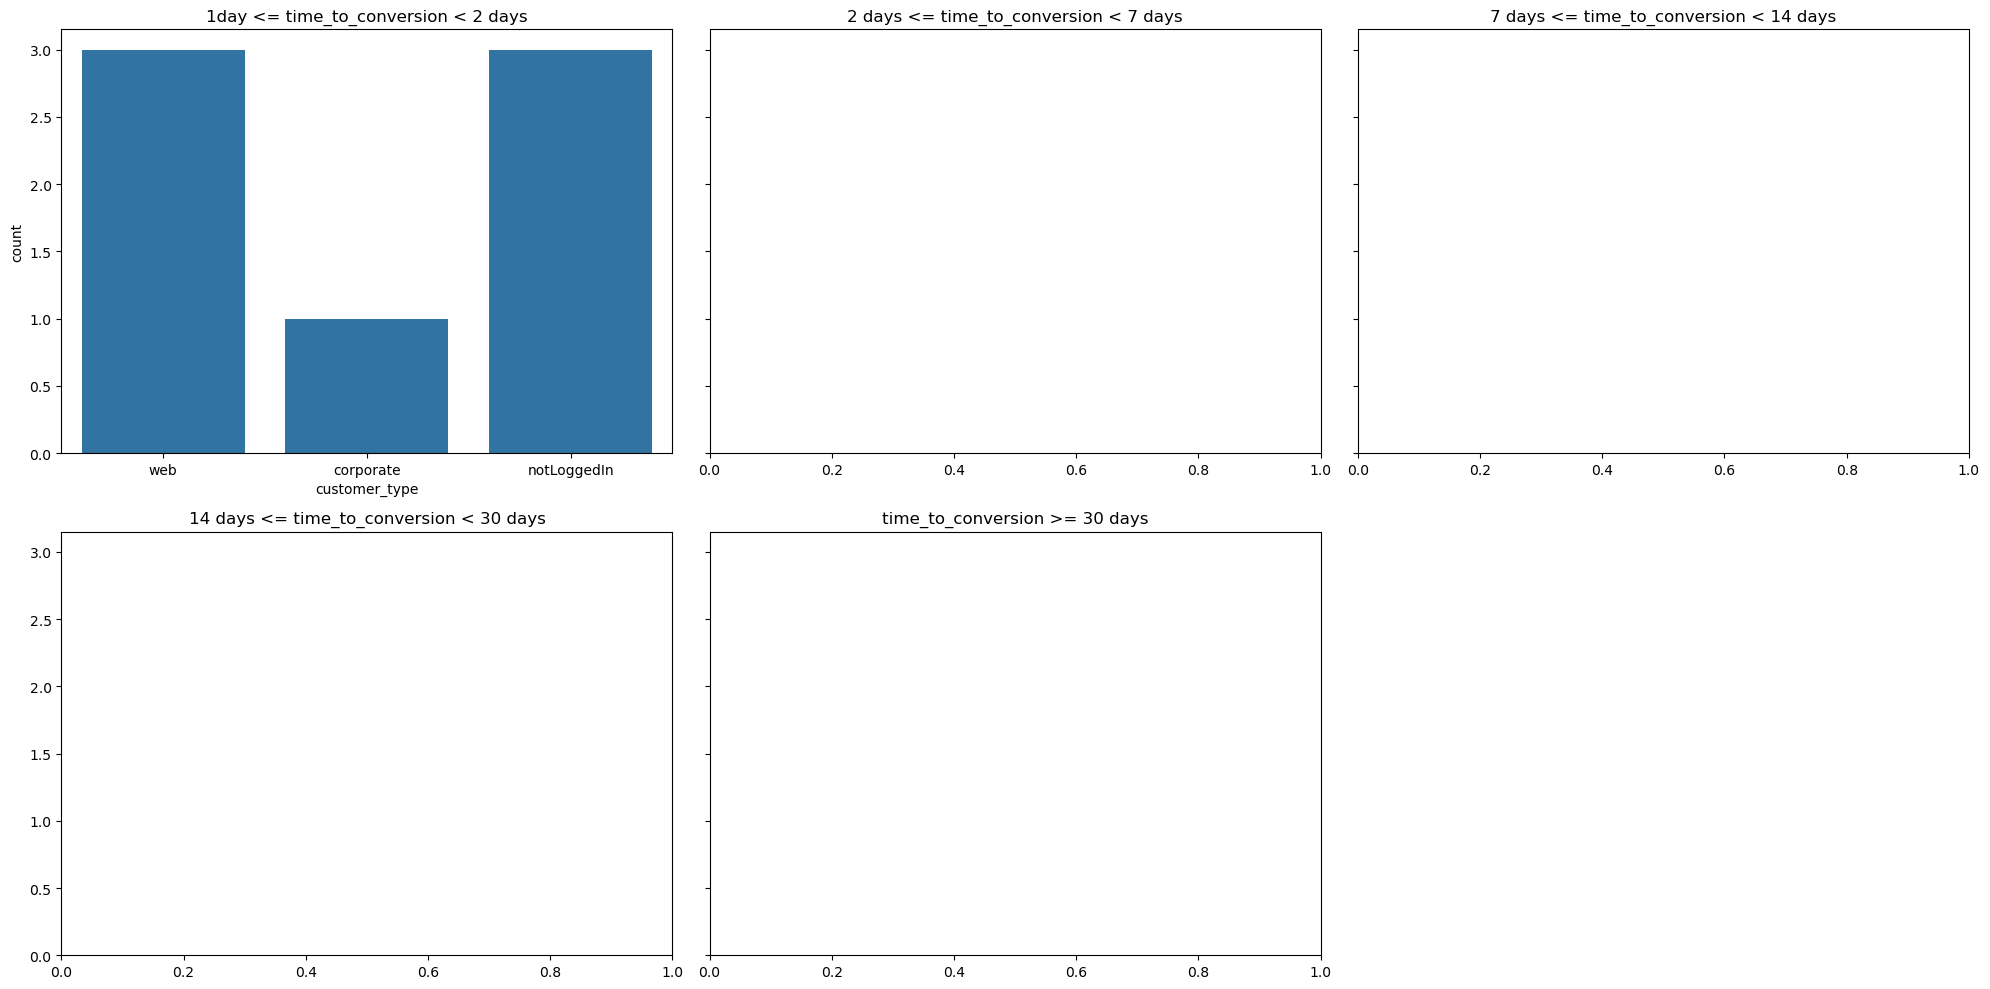

In [66]:
# bar plot of customer_type for each subset in one figure
fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharey=True)
sns.countplot(x='customer_type', data=subset1, ax=axes[0, 0])
sns.countplot(x='customer_type', data=subset2, ax=axes[0, 1])
sns.countplot(x='customer_type', data=subset3, ax=axes[0, 2])
sns.countplot(x='customer_type', data=subset4, ax=axes[1, 0])
sns.countplot(x='customer_type', data=subset5, ax=axes[1, 1])
axes[1, 2].axis('off')  # Hide the last subplot
axes[0, 0].set_title('1day <= time_to_conversion < 2 days')
axes[0, 1].set_title('2 days <= time_to_conversion < 7 days')
axes[0, 2].set_title('7 days <= time_to_conversion < 14 days')
axes[1, 0].set_title('14 days <= time_to_conversion < 30 days')
axes[1, 1].set_title('time_to_conversion >= 30 days')
plt.tight_layout()
plt.show()

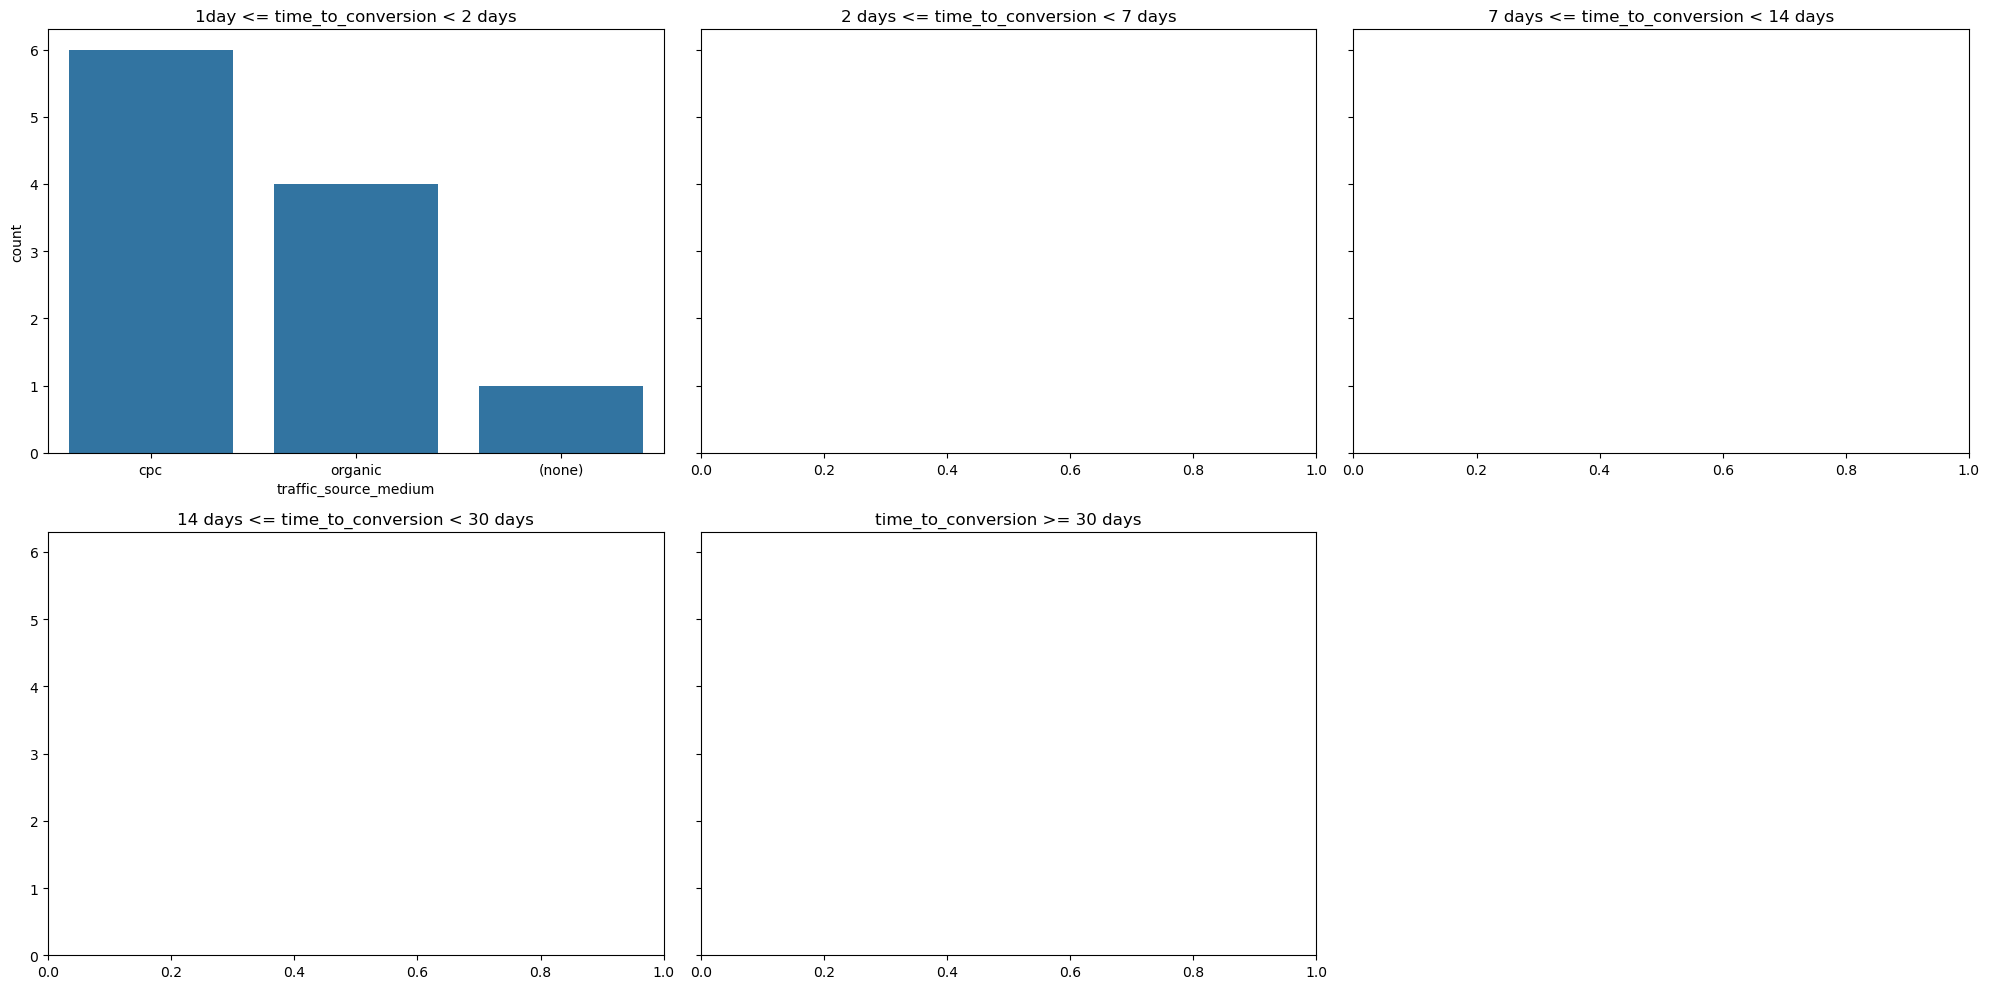

In [67]:
# bar plot of craffic_source_medium for each subset in one figure
fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharey=True)
sns.countplot(x='traffic_source_medium', data=subset1, ax=axes[0, 0])
sns.countplot(x='traffic_source_medium', data=subset2, ax=axes[0, 1])
sns.countplot(x='traffic_source_medium', data=subset3, ax=axes[0, 2])
sns.countplot(x='traffic_source_medium', data=subset4, ax=axes[1, 0])
sns.countplot(x='traffic_source_medium', data=subset5, ax=axes[1, 1])
axes[1, 2].axis('off')  # Hide the last subplot
axes[0, 0].set_title('1day <= time_to_conversion < 2 days')
axes[0, 1].set_title('2 days <= time_to_conversion < 7 days')
axes[0, 2].set_title('7 days <= time_to_conversion < 14 days')
axes[1, 0].set_title('14 days <= time_to_conversion < 30 days')
axes[1, 1].set_title('time_to_conversion >= 30 days')
plt.tight_layout()
plt.show()

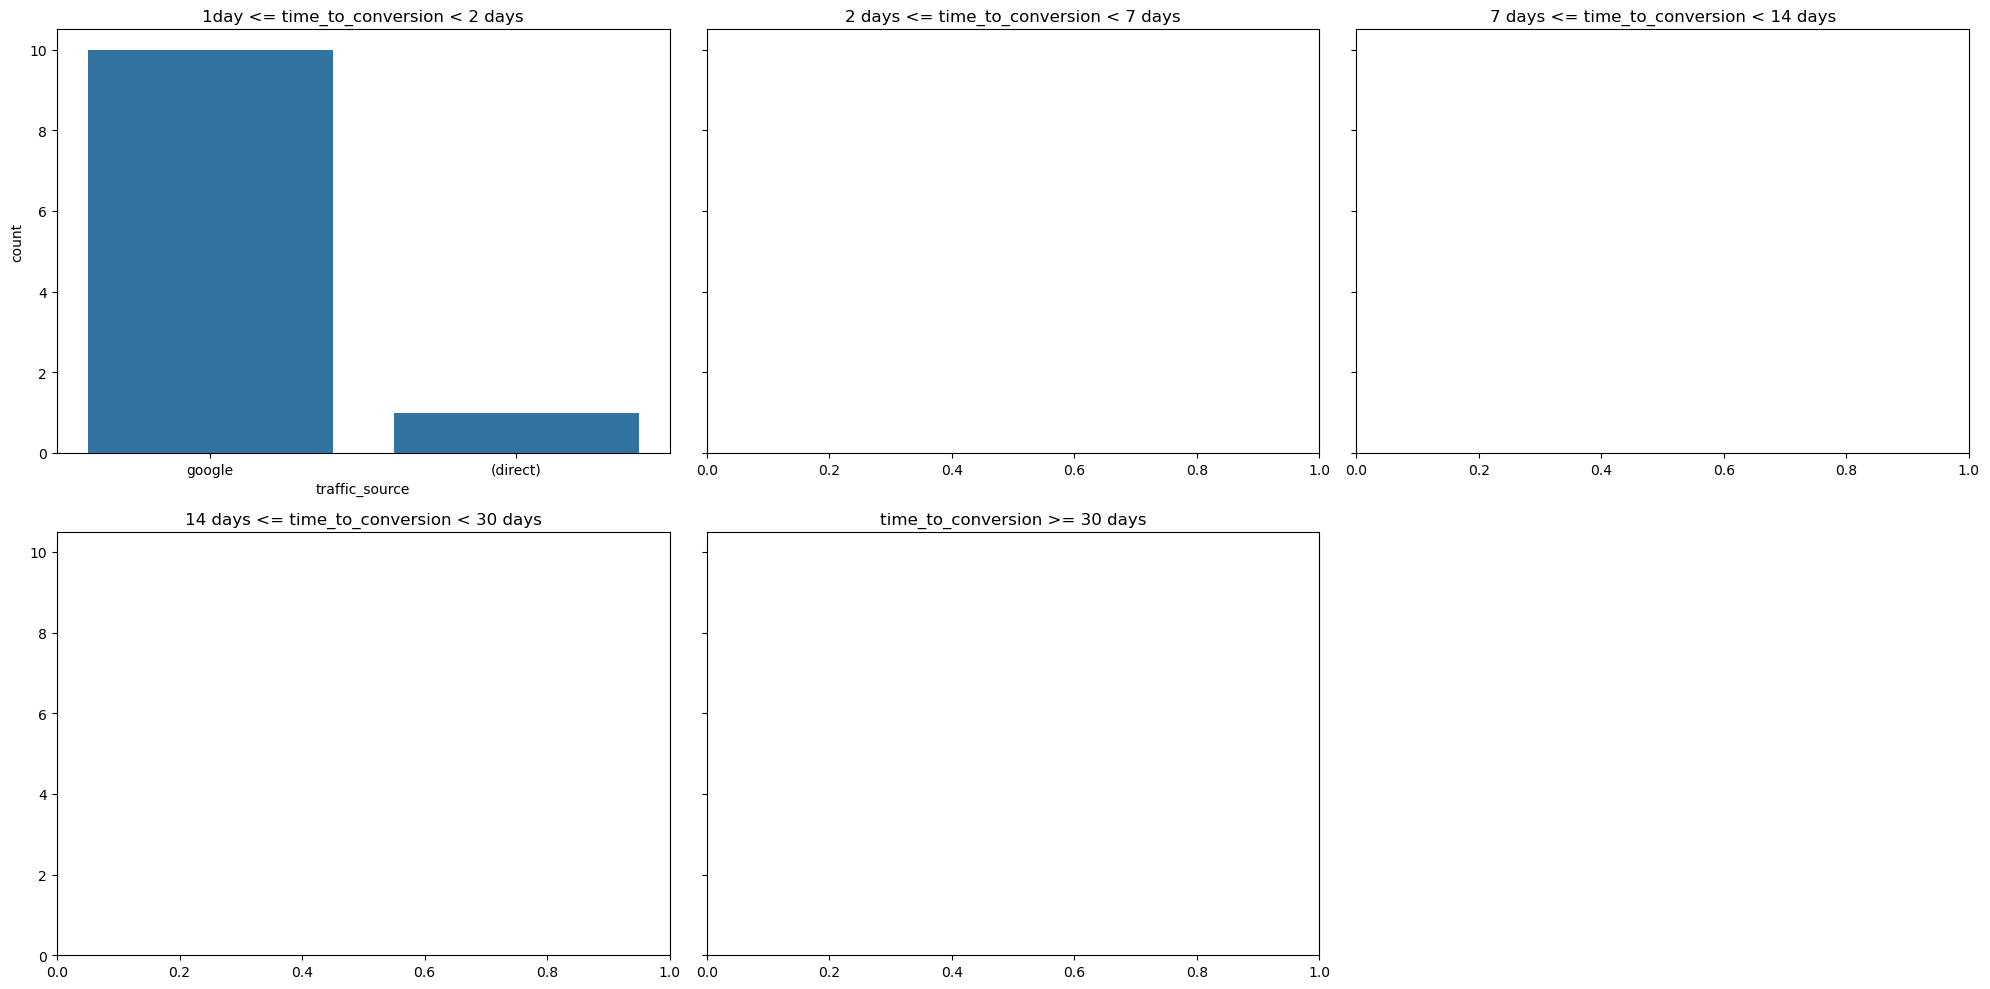

In [68]:
# bar plot of traffic_source for each subset in one figure
fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharey=True)
sns.countplot(x='traffic_source', data=subset1, ax=axes[0, 0])
sns.countplot(x='traffic_source', data=subset2, ax=axes[0, 1])
sns.countplot(x='traffic_source', data=subset3, ax=axes[0, 2])
sns.countplot(x='traffic_source', data=subset4, ax=axes[1, 0])
sns.countplot(x='traffic_source', data=subset5, ax=axes[1, 1])
axes[1, 2].axis('off')  # Hide the last subplot
axes[0, 0].set_title('1day <= time_to_conversion < 2 days')
axes[0, 1].set_title('2 days <= time_to_conversion < 7 days')
axes[0, 2].set_title('7 days <= time_to_conversion < 14 days')
axes[1, 0].set_title('14 days <= time_to_conversion < 30 days')
axes[1, 1].set_title('time_to_conversion >= 30 days')
plt.tight_layout()
plt.show()

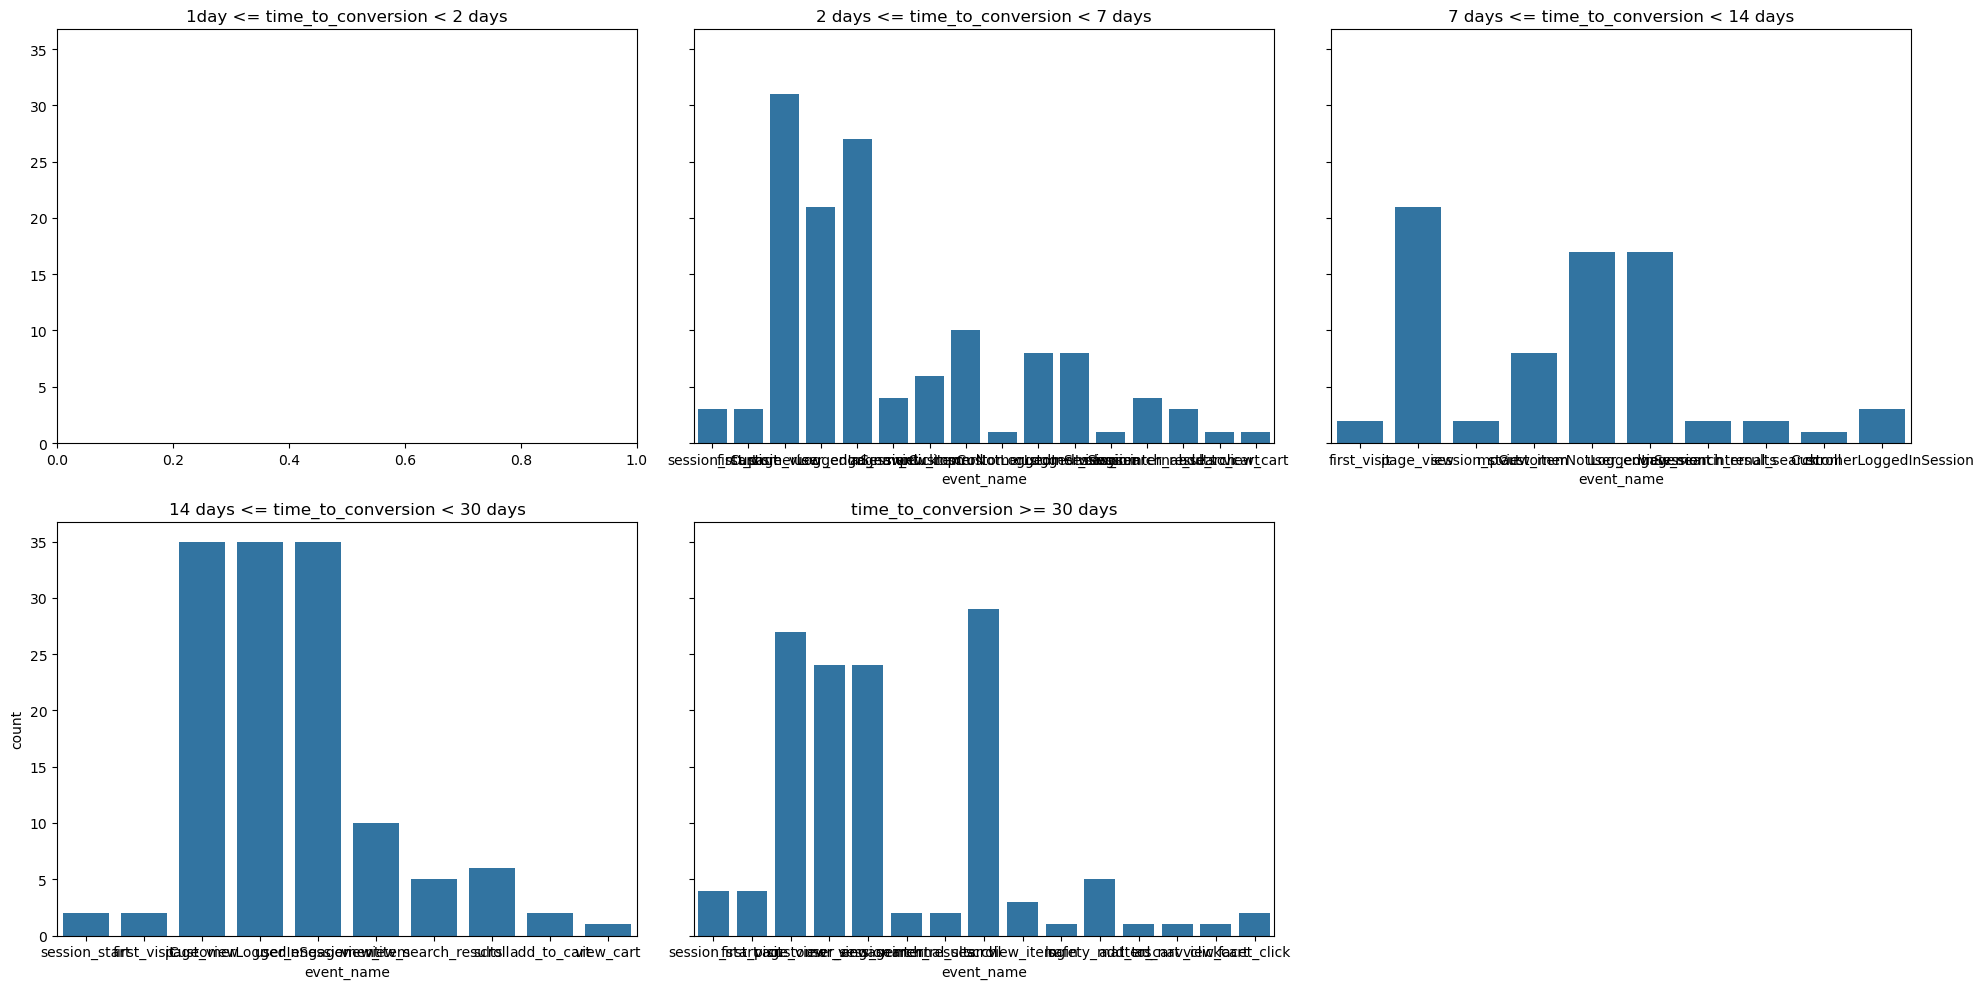

In [69]:
# bar plot of event_name for each subset in one figure
subset01 = conversion_delay[conversion_delay['time_to_conversion'] < t0]
subset02 = conversion_delay[(conversion_delay['time_to_conversion'] >= t0) & 
                                         (conversion_delay['time_to_conversion'] < t1)]   
subset03 = conversion_delay[(conversion_delay['time_to_conversion'] >= t1) & 
                                         (conversion_delay['time_to_conversion'] < t2)]
subset04 = conversion_delay[(conversion_delay['time_to_conversion'] >= t2) & 
                                         (conversion_delay['time_to_conversion'] < t3)]
subset05 = conversion_delay[conversion_delay['time_to_conversion'] >= t3]

fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharey=True)
sns.countplot(x='event_name', data=subset01, ax=axes[0, 0])
sns.countplot(x='event_name', data=subset02, ax=axes[0, 1])
sns.countplot(x='event_name', data=subset03, ax=axes[0, 2])
sns.countplot(x='event_name', data=subset04, ax=axes[1, 0])
sns.countplot(x='event_name', data=subset05, ax=axes[1, 1])
axes[1, 2].axis('off')
axes[0, 0].set_title('1day <= time_to_conversion < 2 days')
axes[0, 1].set_title('2 days <= time_to_conversion < 7 days')
axes[0, 2].set_title('7 days <= time_to_conversion < 14 days')
axes[1, 0].set_title('14 days <= time_to_conversion < 30 days')
axes[1, 1].set_title('time_to_conversion >= 30 days')
plt.tight_layout()
plt.show()

Customers converted within one day:

In [70]:
data[data['time_to_conversion'] < 1000000*60*60*24]['event_name'].value_counts().reset_index()[:15]

event_name   count
0                 page_view  107156
1           user_engagement   98611
2   CustomerLoggedInSession   68106
3                    scroll   53846
4          customer_session   28908
5                 view_item   23039
6         add_shipping_info   20640
7               add_to_cart   18719
8            begin_checkout   11349
9          add_payment_info    8418
10                view_cart    8025
11      view_search_results    7863
12                 purchase    7752
13              first_visit    7579
14            session_start    7579

Customers with a conversion delay between 1 and 2 days:

In [71]:
# list the event name counts in descending order for each subset
subset01['event_name'].value_counts().reset_index()

Empty DataFrame
Columns: [event_name, count]
Index: []

Customers with a conversion delay between 2 and 7 days:

In [72]:
subset02['event_name'].value_counts().reset_index()

event_name  count
0                      page_view     31
1                user_engagement     27
2        CustomerLoggedInSession     21
3                         scroll     10
4               customer_session      8
5      mpCustomerLoggedInSession      8
6                      view_item      6
7                   ad_nav_click      4
8            view_search_results      4
9                  session_start      3
10                   first_visit      3
11               internal_search      3
12                         login      1
13  mpCustomerNotLoggedInSession      1
14                   add_to_cart      1
15                     view_cart      1

Customers with a conversion delay between 7 and 14 days:

In [73]:
subset03['event_name'].value_counts().reset_index()

event_name  count
0                     page_view     21
1               user_engagement     17
2  mpCustomerNotLoggedInSession     17
3                     view_item      8
4       CustomerLoggedInSession      3
5                   first_visit      2
6                 session_start      2
7           view_search_results      2
8               internal_search      2
9                        scroll      1

Customers with a conversion delay between 14 and 30 days:

In [74]:
subset04['event_name'].value_counts().reset_index()

event_name  count
0  CustomerLoggedInSession     35
1                page_view     35
2          user_engagement     35
3                view_item     10
4                   scroll      6
5      view_search_results      5
6              first_visit      2
7            session_start      2
8              add_to_cart      2
9                view_cart      1

Customers with a conversion delay od 30+ days:

In [75]:
subset05['event_name'].value_counts().reset_index()

event_name  count
0                scroll     29
1             page_view     27
2       user_engagement     24
3      customer_session     24
4        safety_matters      5
5           first_visit      4
6         session_start      4
7             view_item      3
8   view_search_results      2
9       internal_search      2
10          facet_click      2
11                login      1
12          add_to_cart      1
13         ad_nav_click      1
14            view_cart      1

# Feature Engineering

### One Hot Encode and merge event_name

In [76]:
data['event_name'].value_counts()

event_name
page_view                       107270
user_engagement                  98714
CustomerLoggedInSession          68165
scroll                           53892
customer_session                 28940
                                 ...  
videoProgress50                      1
vending_form_fill                    1
corporate_accounts_form_fill         1
account_order_search                 1
account_order_search_filter          1
Name: count, Length: 65, dtype: int64

In [77]:
# one hot encode event_name
data = pd.get_dummies(data, columns=['event_name'], drop_first=False)
data.shape

(505491, 73)

In [78]:
'event_name' in data.columns

False

In [79]:
data.head(2)

user_pseudo_id  session_id  \
0  +JCOGYuIB0UiMuCAfoa19Zx4/kyAS1mL/oiJpA8Efc4=.1...  1753451127   
1  +JCOGYuIB0UiMuCAfoa19Zx4/kyAS1mL/oiJpA8Efc4=.1...  1753451127   

   session_duration customer_type device_category   traffic_source  \
0         250944587           NaN         desktop  app.jotform.com   
1         250944587           NaN         desktop  app.jotform.com   

  traffic_source_medium  time_to_conversion  \
0              referral           242274347   
1              referral           242274347   

   event_name_CustomerLoggedInSession  event_name_account_add_to_cart  ...  \
0                               False                           False  ...   
1                               False                           False  ...   

   event_name_user_engagement  event_name_user_session  \
0                       False                    False   
1                       False                    False   

   event_name_vending_form_fill  event_name_videoProgress25  \
0                         False                       False   
1                         False                       False   

   event_name_videoProgress50  event_name_videoProgress75  \
0                       False                       False   
1                       False                       False   

   event_name_view_cart  event_name_view_item  event_name_view_item_list  \
0                 False                 False                      False   
1                 False                 False                      False   

   event_name_view_search_results  
0                           False  
1                           False  

[2 rows x 73 columns]

In [80]:
# assign 0 to False and 1 to True in the boolean columns
bool_cols = data.select_dtypes(include=['bool']).columns
data[bool_cols] = data[bool_cols].astype(int)
data.head(2)

user_pseudo_id  session_id  \
0  +JCOGYuIB0UiMuCAfoa19Zx4/kyAS1mL/oiJpA8Efc4=.1...  1753451127   
1  +JCOGYuIB0UiMuCAfoa19Zx4/kyAS1mL/oiJpA8Efc4=.1...  1753451127   

   session_duration customer_type device_category   traffic_source  \
0         250944587           NaN         desktop  app.jotform.com   
1         250944587           NaN         desktop  app.jotform.com   

  traffic_source_medium  time_to_conversion  \
0              referral           242274347   
1              referral           242274347   

   event_name_CustomerLoggedInSession  event_name_account_add_to_cart  ...  \
0                                   0                               0  ...   
1                                   0                               0  ...   

   event_name_user_engagement  event_name_user_session  \
0                           0                        0   
1                           0                        0   

   event_name_vending_form_fill  event_name_videoProgress25  \
0                             0                           0   
1                             0                           0   

   event_name_videoProgress50  event_name_videoProgress75  \
0                           0                           0   
1                           0                           0   

   event_name_view_cart  event_name_view_item  event_name_view_item_list  \
0                     0                     0                          0   
1                     0                     0                          0   

   event_name_view_search_results  
0                               0  
1                               0  

[2 rows x 73 columns]

In [81]:
data.shape

(505491, 73)

In [82]:
data[['user_pseudo_id', 'session_id']].value_counts()

user_pseudo_id         session_id
393010522.1741963718   1741963718    1130
2007368973.1741097892  1741097892     702
1896432456.1749804712  1749804711     678
962357801.1742485747   1742485746     569
835274607.1740102421   1740102421     562
                                     ... 
1978830996.1739228266  1739228265       8
1242458974.174898      1748976952       6
1852103760.1746826056  1746826056       6
175452251.1752089958   1752089957       5
1252877196.175198      1751979431       5
Name: count, Length: 7592, dtype: int64

In [83]:
# display columns exclude those with 'event_name_*'
[col for col in data.columns if not col.startswith('event_name_')]

['user_pseudo_id',
 'session_id',
 'session_duration',
 'customer_type',
 'device_category',
 'traffic_source',
 'traffic_source_medium',
 'time_to_conversion']

In [84]:
# group by user_pseudo_id and session_id, then sum the event_name_* columns
data_event_count = data.groupby(['user_pseudo_id', 'session_id'])[bool_cols].sum().reset_index()
data_event_count.shape

(7592, 67)

In [85]:
[col for col in data_event_count.columns if not col.startswith('event_name_')]

['user_pseudo_id', 'session_id']

In [86]:
data_other_cols = data.drop(columns=bool_cols)
# drop duplicate rows
data_other_cols = data_other_cols.drop_duplicates(subset=['user_pseudo_id', 'session_id'])
data_other_cols.shape

(7592, 8)

In [87]:
data_other_cols.columns

Index(['user_pseudo_id', 'session_id', 'session_duration', 'customer_type',
       'device_category', 'traffic_source', 'traffic_source_medium',
       'time_to_conversion'],
      dtype='object')

In [88]:
final_input = pd.merge(data_event_count, data_other_cols, on=['user_pseudo_id', 'session_id'], how='left')
final_input.shape

(7592, 73)

In [89]:
final_input.head(2)

user_pseudo_id  session_id  event_name_CustomerLoggedInSession  \
0   1443178.175131  1751312891                                   4   
1  12731018.174534  1745337348                                  10   

   event_name_account_add_to_cart  event_name_account_all_clicks  \
0                               0                              0   
1                               0                              0   

   event_name_account_order_search  event_name_account_order_search_filter  \
0                                0                                       0   
1                                0                                       0   

   event_name_account_order_selected  event_name_account_update_address  \
0                                  0                                  0   
1                                  0                                  0   

   event_name_ad_add_address  ...  event_name_view_cart  event_name_view_item  \
0                          0  ...                     1                     1   
1                          0  ...                     1                     2   

   event_name_view_item_list  event_name_view_search_results  \
0                          0                               0   
1                          0                               0   

   session_duration  customer_type  device_category  traffic_source  \
0         293893231    notLoggedIn          desktop            bing   
1         295883665            web          desktop        (direct)   

   traffic_source_medium  time_to_conversion  
0                    cpc           288845121  
1                 (none)           238073862  

[2 rows x 73 columns]

In [90]:
len(final_input['device_category'].value_counts()) + len(
    final_input['traffic_source'].value_counts()) + len(
        final_input['traffic_source_medium'].value_counts())

78

In [91]:
# one hot encode and device_category, traffic_source, and traffic_source_medium
final_input = pd.get_dummies(final_input, columns=['customer_type', 'device_category', 'traffic_source', 'traffic_source_medium'], drop_first=False)

# assign 0 to False and 1 to True in the boolean columns
bool_cols = final_input.select_dtypes(include=['bool']).columns
final_input[bool_cols] = final_input[bool_cols].astype(int)

final_input.shape

(7592, 150)

In [92]:
final_input.head(2)

user_pseudo_id  session_id  event_name_CustomerLoggedInSession  \
0   1443178.175131  1751312891                                   4   
1  12731018.174534  1745337348                                  10   

   event_name_account_add_to_cart  event_name_account_all_clicks  \
0                               0                              0   
1                               0                              0   

   event_name_account_order_search  event_name_account_order_search_filter  \
0                                0                                       0   
1                                0                                       0   

   event_name_account_order_selected  event_name_account_update_address  \
0                                  0                                  0   
1                                  0                                  0   

   event_name_ad_add_address  ...  traffic_source_medium_SH  \
0                          0  ...                         0   
1                          0  ...                         0   

   traffic_source_medium_Skimlinks  traffic_source_medium_Sovrn Inc  \
0                                0                                0   
1                                0                                0   

   traffic_source_medium_Wildfire Systems  traffic_source_medium_banner  \
0                                       0                             0   
1                                       0                             0   

   traffic_source_medium_cpc  traffic_source_medium_email  \
0                          1                            0   
1                          0                            0   

   traffic_source_medium_organic  traffic_source_medium_referral  \
0                              0                               0   
1                              0                               0   

   traffic_source_medium_utm_medium=email  
0                                       0  
1                                       0  

[2 rows x 150 columns]

In [93]:
# check special JSON characters (apart from [^a-zA-Z0-9_]) in X_train.columns
final_input.columns[final_input.columns.str.contains(r'[^a-zA-Z0-9_]')]

Index(['traffic_source_(direct)', 'traffic_source_Data Not Available',
       'traffic_source_admin.shopify.com', 'traffic_source_app.3pmercury.com',
       'traffic_source_app.asana.com', 'traffic_source_app.clickup.com',
       'traffic_source_app.jotform.com', 'traffic_source_assistant.order.co',
       'traffic_source_chatgpt.com', 'traffic_source_docs.google.com',
       'traffic_source_ebiz-myus-com.go.akamai-access.com',
       'traffic_source_ecovative.quickbase.com',
       'traffic_source_excel.officeapps.live.com',
       'traffic_source_fuse-us.masterdataonline.com',
       'traffic_source_hs-3856451.s.hubspotemail.net',
       'traffic_source_kb.iflyworld.com',
       'traffic_source_kinleyconstruction0.sharepoint.com',
       'traffic_source_kvalincorporated.sharepoint.com',
       'traffic_source_labspend.com', 'traffic_source_link.edgepilot.com',
       'traffic_source_lsems.gravityzone.bitdefender.com',
       'traffic_source_m.facebook.com',
       'traffic_source_mag

In [94]:
# remove '(', ')', and ',', replace spaces with underscores
final_input.columns = final_input.columns.str.replace(r'[(),]', '', regex=True).str.replace(' ', '_')

In [95]:
final_input.columns[final_input.columns.str.contains(r'[^a-zA-Z0-9_]')]

Index(['traffic_source_admin.shopify.com', 'traffic_source_app.3pmercury.com',
       'traffic_source_app.asana.com', 'traffic_source_app.clickup.com',
       'traffic_source_app.jotform.com', 'traffic_source_assistant.order.co',
       'traffic_source_chatgpt.com', 'traffic_source_docs.google.com',
       'traffic_source_ebiz-myus-com.go.akamai-access.com',
       'traffic_source_ecovative.quickbase.com',
       'traffic_source_excel.officeapps.live.com',
       'traffic_source_fuse-us.masterdataonline.com',
       'traffic_source_hs-3856451.s.hubspotemail.net',
       'traffic_source_kb.iflyworld.com',
       'traffic_source_kinleyconstruction0.sharepoint.com',
       'traffic_source_kvalincorporated.sharepoint.com',
       'traffic_source_labspend.com', 'traffic_source_link.edgepilot.com',
       'traffic_source_lsems.gravityzone.bitdefender.com',
       'traffic_source_m.facebook.com',
       'traffic_source_magidglove-3856451.hs-sites.com',
       'traffic_source_mail.google.com',

### Binning & Check correlations

In [96]:
final_input['session_duration'] = final_input['session_duration'].apply(lambda x: x / (1000000 * 60))

In [97]:
final_input['time_to_conversion'] = final_input['time_to_conversion'] / (60 * 1000000)  # convert microseconds to minutes

# display the count of values for all bins
final_input['time_to_conversion'] = pd.cut(final_input['time_to_conversion'],
                                  bins=[0, 5, 15, 30, 60, 120, np.inf],
                                  labels=['0-5 min', '5-15 min', '15-30 min', '30-60 min', 
                                  '1-2 h', '2h+'],
                                  right=False)
final_input['time_to_conversion'].value_counts().sort_index()

time_to_conversion
0-5 min      1850
5-15 min     3030
15-30 min    1188
30-60 min     663
1-2 h         383
2h+           478
Name: count, dtype: int64

In [98]:
y0 = final_input['time_to_conversion'].copy()
y0 = y0.cat.codes

In [99]:
# display the correlation between time_to_conversion and other features,
corr = final_input.drop(columns=['user_pseudo_id', 'session_id', 'time_to_conversion']).corrwith(y0)

In [100]:
corr.sort_values(ascending=False)[:10]

session_duration                      0.502341
event_name_page_view                  0.448188
event_name_user_engagement            0.445319
event_name_view_item                  0.415789
event_name_add_to_cart                0.291963
event_name_scroll                     0.264576
event_name_CustomerLoggedInSession    0.260592
event_name_view_search_results        0.249636
event_name_view_cart                  0.246211
event_name_remove_from_cart           0.226026
dtype: float64

In [101]:
corr.sort_values(ascending=True)[:10]

event_name_ad_portal_add_to_cart           -0.034903
event_name_purchase                        -0.025801
traffic_source_direct                      -0.024051
traffic_source_medium_none                 -0.024051
traffic_source_excel.officeapps.live.com   -0.020457
customer_type_corporate                    -0.019337
traffic_source_magento                     -0.018111
traffic_source_medium_Skimlinks            -0.016342
traffic_source_chatgpt.com                 -0.016205
customer_type_notLoggedIn                  -0.015287
dtype: float64

In [102]:
final_input.to_csv('final_input_0801.csv', index=False)

Apply down sampling to balance the dataset

In [103]:
# separate majority and minority classes
majority1 = final_input[final_input['time_to_conversion'] == '0-5 min']
majority2 = final_input[final_input['time_to_conversion'] == '5-15 min']
majority3 = final_input[final_input['time_to_conversion'] == '15-30 min']
majority4 = final_input[final_input['time_to_conversion'] == '30-60 min']
majority6 = final_input[final_input['time_to_conversion'] == '2h+']
minority = final_input[final_input['time_to_conversion'] == '1-2 h']

# down sample majority class
for majority in [majority1, majority2, majority3, majority4, majority6]:
    majority_downsampled = resample(majority,
                                    replace=False,  # sample without replacement
                                    n_samples=383,  # to match minority class
                                    random_state=42)

    # combine minority class with downsampled majority class
    final_input_2 = pd.concat([majority_downsampled, minority])
    minority = final_input_2

# reset index
final_input_2.reset_index(drop=True, inplace=True)
final_input_2.shape

(2298, 150)

In [104]:
final_input_2['time_to_conversion'].value_counts().sort_index()

time_to_conversion
0-5 min      383
5-15 min     383
15-30 min    383
30-60 min    383
1-2 h        383
2h+          383
Name: count, dtype: int64

In [105]:
final_input_2.to_csv('final_input_downsampled_0801.csv', index=False)

# Modeling

Decision Tree

Best parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best cross-validation score: 0.688258204004265
Test accuracy: 0.7108695652173913
              precision    recall  f1-score   support

     0-5 min       0.82      0.69      0.75        85
       1-2 h       0.69      0.77      0.72        77
   15-30 min       0.70      0.73      0.72        71
         2h+       0.64      0.91      0.75        77
   30-60 min       0.73      0.67      0.70        78
    5-15 min       0.73      0.49      0.58        72

    accuracy                           0.71       460
   macro avg       0.72      0.71      0.70       460
weighted avg       0.72      0.71      0.71       460



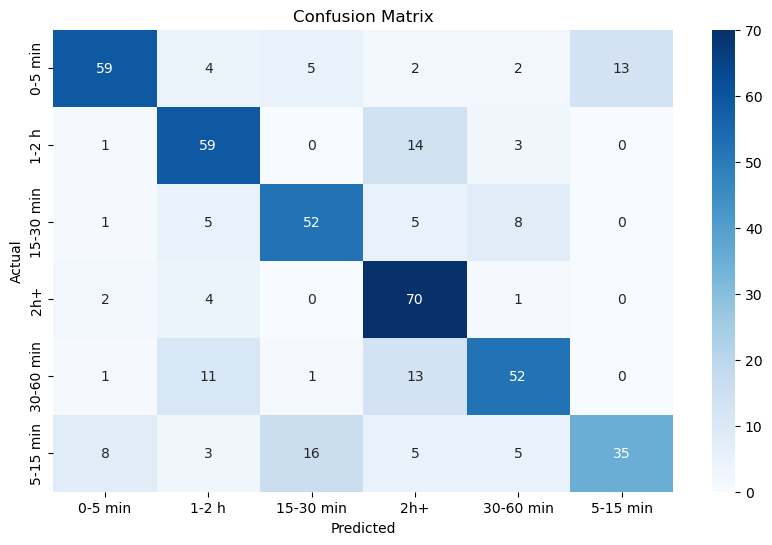

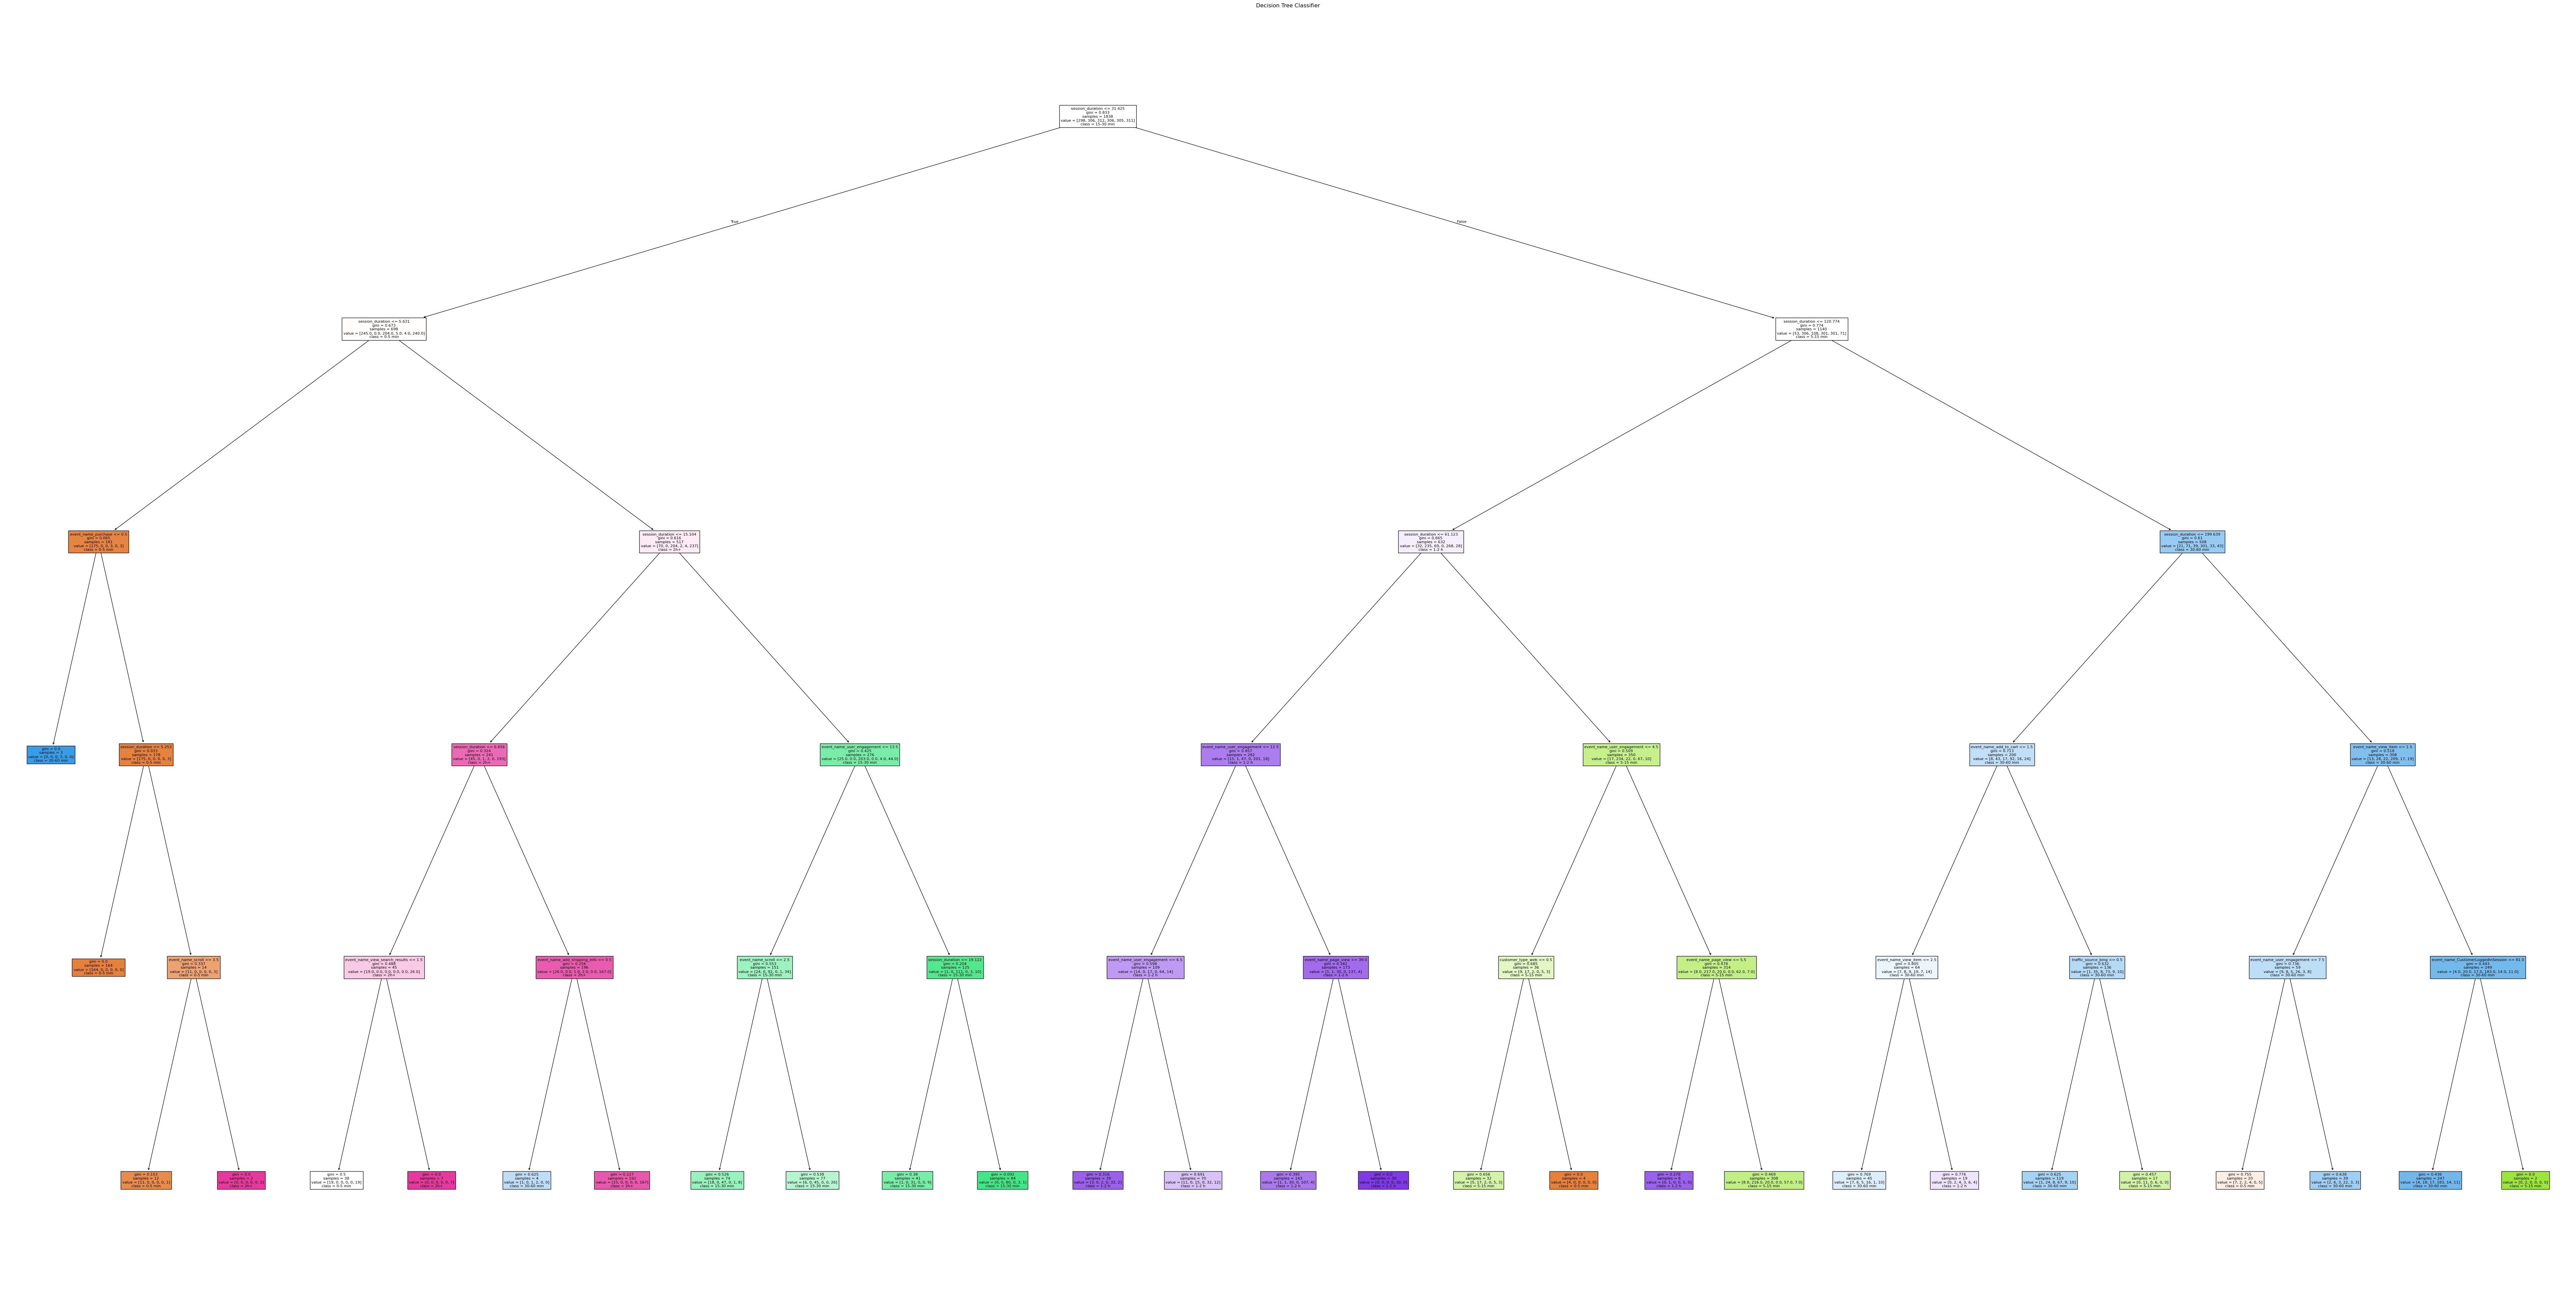

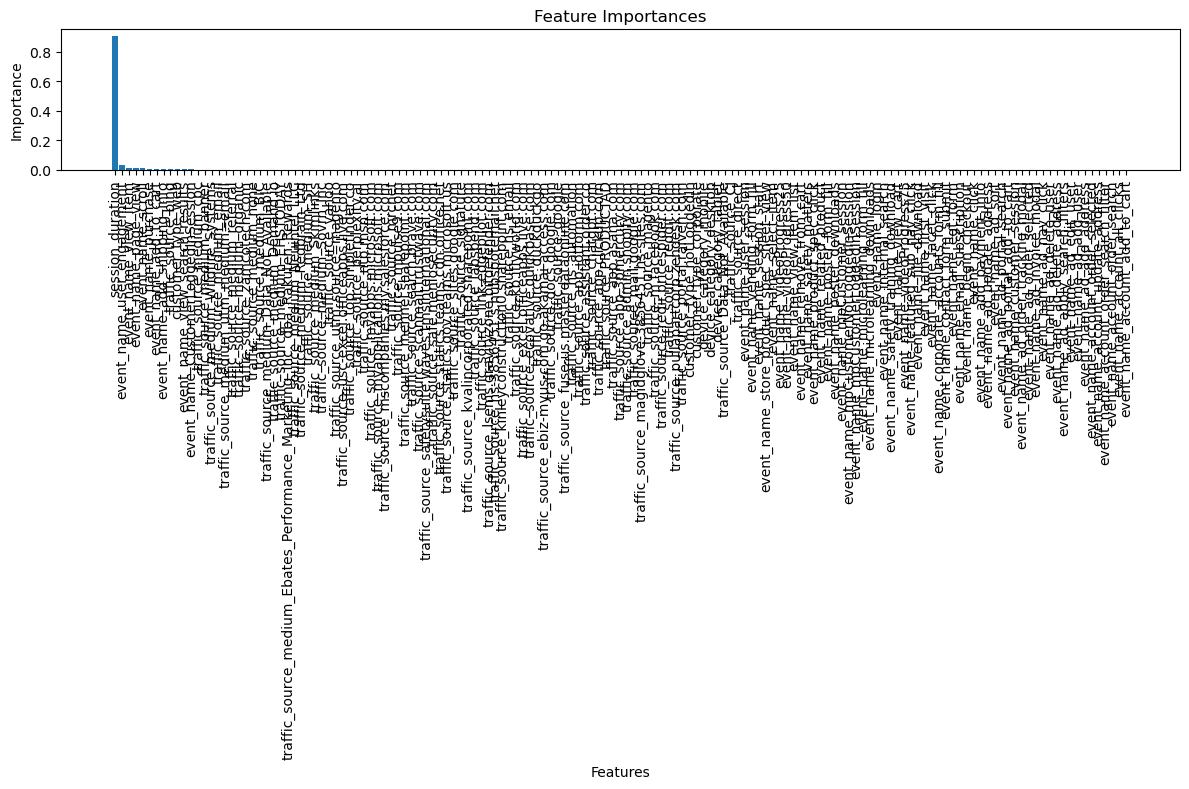

In [106]:
y = final_input_2['time_to_conversion']
X = final_input_2.drop(columns=['user_pseudo_id', 'session_id', 'time_to_conversion'])

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train a decision tree classifier with hypertuning
dt = DecisionTreeClassifier(random_state=42)
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_dt = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# save the best model
joblib.dump(best_dt, 'best_decision_tree_model.pkl')

# load the best model
best_dt = joblib.load('best_decision_tree_model.pkl')

# evaluate the model on the test set
y_pred = best_dt.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# visualize the confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_pred), yticklabels=np.unique(y_pred))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# visualize the decision tree
plt.figure(figsize=(100, 50))
plot_tree(best_dt, filled=True, feature_names=X.columns, class_names=y.cat.categories)
plt.title("Decision Tree Classifier")

# save the decision tree plot
plt.savefig('decision_tree_classifier.png', bbox_inches='tight')

# feature importance
feature_importances = best_dt.feature_importances_
indices = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), feature_importances[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# save feature importance to csv
feature_importance_df = pd.DataFrame({
    'feature': X.columns[indices],
    'importance': feature_importances[indices]
})
feature_importance_df.to_csv('dt_feature_importances.csv', index=False)


In [108]:
from sklearn.tree import export_text

# print the tree structure in text format
tree_structure = export_text(best_dt, feature_names=list(X.columns))
print(tree_structure)

|--- session_duration <= 31.43
|   |--- session_duration <= 5.63
|   |   |--- event_name_purchase <= 0.50
|   |   |   |--- class: 2h+
|   |   |--- event_name_purchase >  0.50
|   |   |   |--- session_duration <= 5.25
|   |   |   |   |--- class: 0-5 min
|   |   |   |--- session_duration >  5.25
|   |   |   |   |--- event_name_scroll <= 3.50
|   |   |   |   |   |--- class: 0-5 min
|   |   |   |   |--- event_name_scroll >  3.50
|   |   |   |   |   |--- class: 5-15 min
|   |--- session_duration >  5.63
|   |   |--- session_duration <= 15.10
|   |   |   |--- session_duration <= 6.66
|   |   |   |   |--- event_name_view_search_results <= 1.50
|   |   |   |   |   |--- class: 0-5 min
|   |   |   |   |--- event_name_view_search_results >  1.50
|   |   |   |   |   |--- class: 5-15 min
|   |   |   |--- session_duration >  6.66
|   |   |   |   |--- event_name_add_shipping_info <= 0.50
|   |   |   |   |   |--- class: 2h+
|   |   |   |   |--- event_name_add_shipping_info >  0.50
|   |   |   |   |   

KNN

KNN Test accuracy: 0.6804347826086956
              precision    recall  f1-score   support

     0-5 min       0.82      0.65      0.72        85
       1-2 h       0.61      0.78      0.69        77
   15-30 min       0.67      0.68      0.67        71
         2h+       0.64      0.78      0.70        77
   30-60 min       0.70      0.64      0.67        78
    5-15 min       0.69      0.56      0.62        72

    accuracy                           0.68       460
   macro avg       0.69      0.68      0.68       460
weighted avg       0.69      0.68      0.68       460



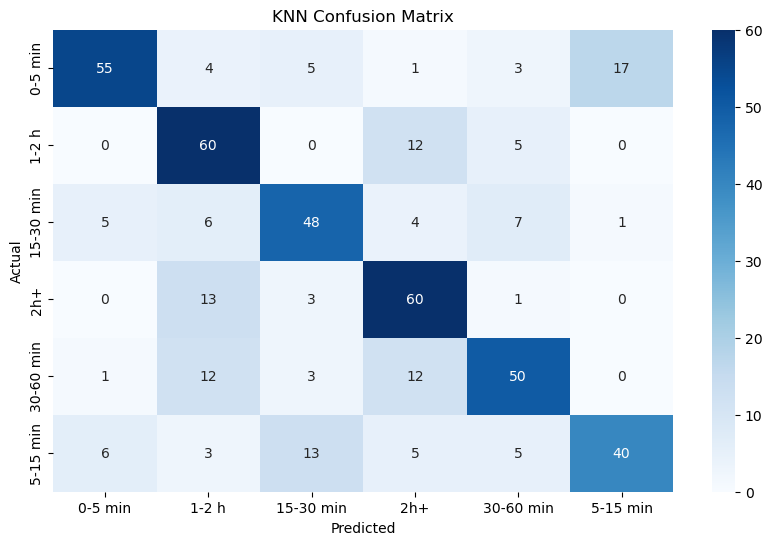

In [53]:
# KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# evaluate the KNN model on the test set
y_pred_knn = knn.predict(X_test)
print("KNN Test accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

# confusion matrix for KNN
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_pred_knn), yticklabels=np.unique(y_pred_knn))
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# save feature importance
feature_importance_df = pd.DataFrame({
    'feature': X.columns[indices],
    'importance': feature_importances[indices]
})

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 844
[LightGBM] [Info] Number of data points in the train set: 1838, number of used features: 41
[LightGBM] [Info] Start training from score -1.819340
[LightGBM] [Info] Start training from score -1.792848
[LightGBM] [Info] Start training from score -1.773430
[LightGBM] [Info] Start training from score -1.792848
[LightGBM] [Info] Start training from score -1.796122
[LightGBM] [Info] Start training from score -1.776640
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best parameters found:  {'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 100, 'num_leaves': 31}
Accuracy:  0.7086956521739131
Classification Report:
               precision    rec

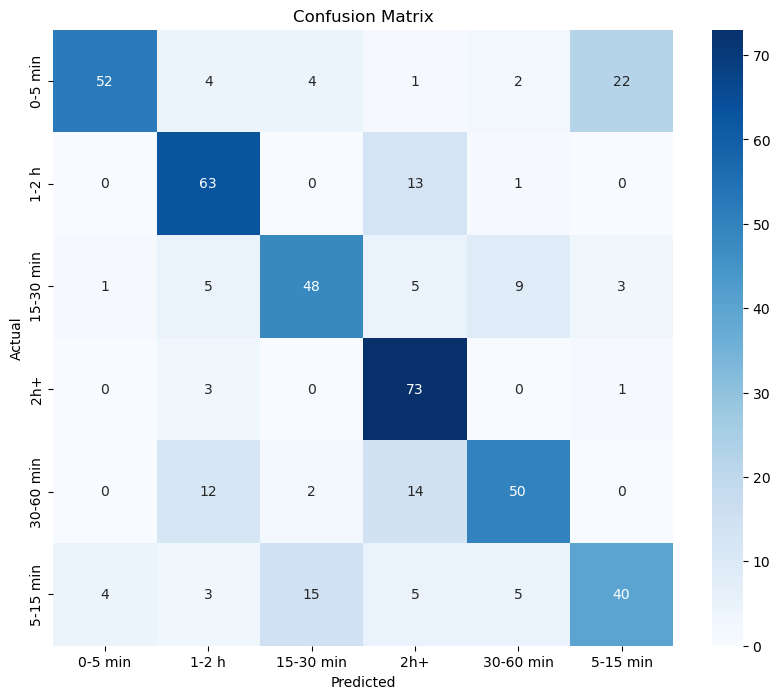

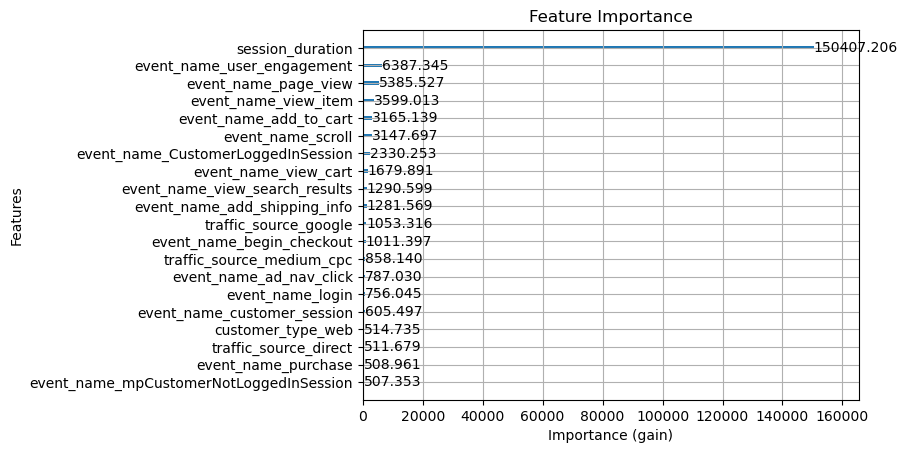

In [54]:
# train lightgbm model with hypertuning
# define the model
model = lgb.LGBMClassifier(objective='multiclass', num_classes=len(y.unique()), random_state=42)

# define the parameters for grid search
param_grid = {
    'num_leaves': [31, 50, 100],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300]
}

# perform grid search
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)

# Remove special JSON characters from feature names before fitting
X_train_safe = X_train.copy()
X_train_safe.columns = [col.replace('<', '_').replace('>', '_').replace('"', '_').replace("'", "_") for col in X_train_safe.columns]
y_train_safe = y_train.copy()
y_train_safe.columns = X_train_safe.columns  # ensure columns match

grid_search.fit(X_train_safe, y_train_safe)

# print the best parameters
print("Best parameters found: ", grid_search.best_params_)

# train the model with the best parameters
best_model = grid_search.best_estimator_

# save the model
joblib.dump(best_model, 'best_lightgbm_model.pkl')

# load the model
loaded_model = joblib.load('best_lightgbm_model.pkl')

# make predictions on the test set
y_pred = best_model.predict(X_test)

# evaluate the model
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# visualize feature importance
lgb.plot_importance(best_model, max_num_features=20, importance_type='gain',
                    title='Feature Importance', xlabel='Importance (gain)', ylabel='Features')
plt.show()

# save the feature importance to csv
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
})
feature_importance_df.to_csv('lgbm_feature_importances.csv', index=False)

Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation score: 0.5060034356118944
Test accuracy: 0.5108695652173914
              precision    recall  f1-score   support

     0-5 min       0.58      0.68      0.63        85
       1-2 h       0.57      0.44      0.50        77
   15-30 min       0.46      0.38      0.42        71
         2h+       0.63      0.82      0.71        77
   30-60 min       0.43      0.32      0.37        78
    5-15 min       0.34      0.39      0.36        72

    accuracy                           0.51       460
   macro avg       0.50      0.51      0.50       460
weighted avg       0.50      0.51      0.50       460



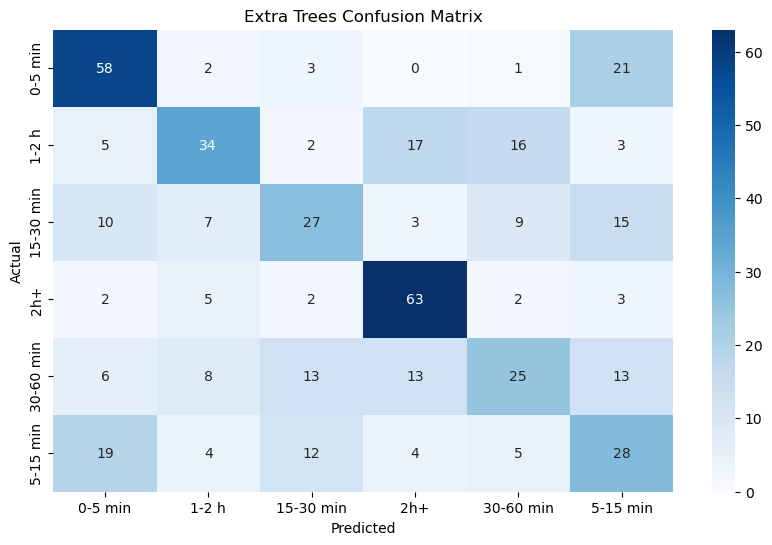

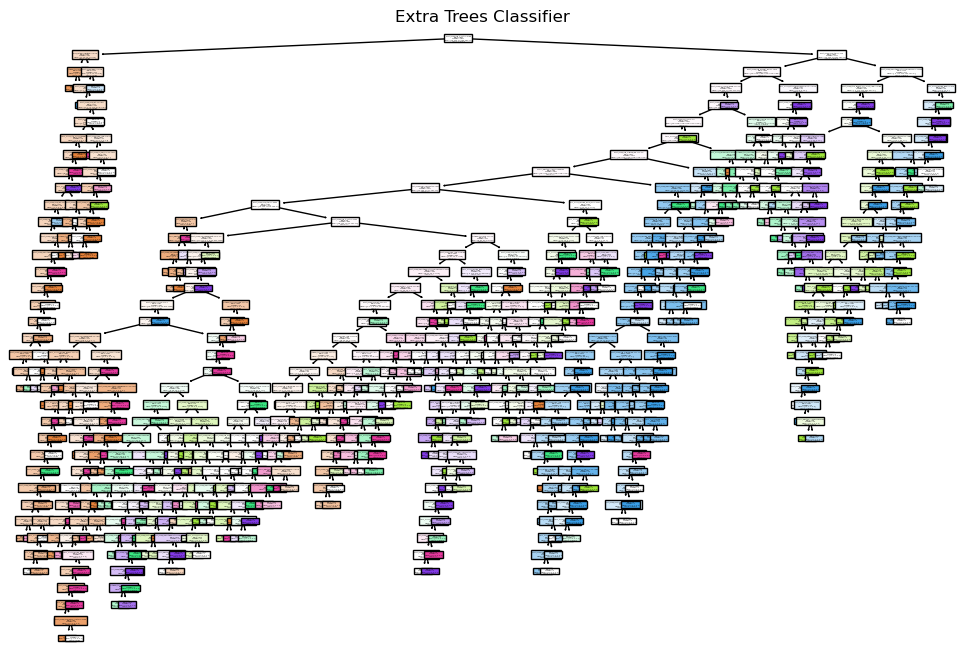

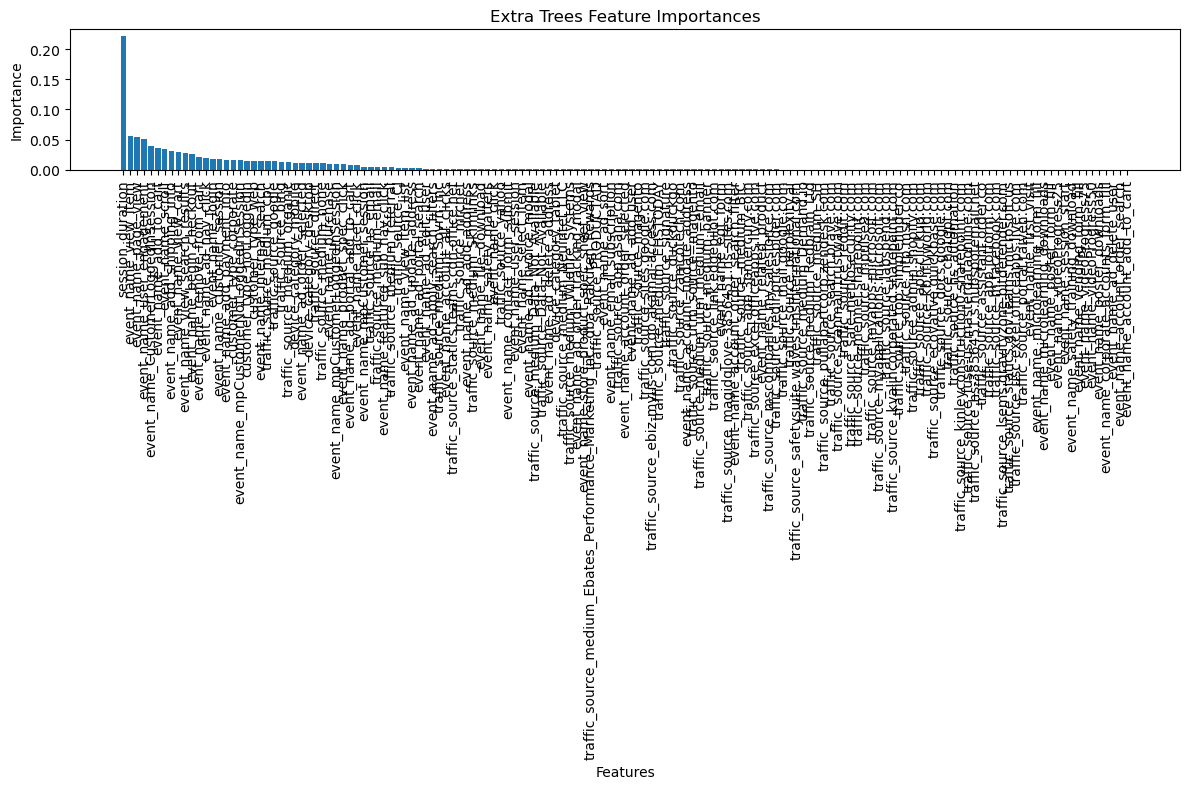

In [55]:
# train etra trees classifier with hypertuning
extra_trees = ExtraTreesClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(extra_trees, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_extra_trees = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# save the best model
joblib.dump(best_extra_trees, 'best_extra_trees_model.pkl')
# load the best model
best_extra_trees = joblib.load('best_extra_trees_model.pkl')

# evaluate the model on the test set
y_pred_extra_trees = best_extra_trees.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, y_pred_extra_trees))
print(classification_report(y_test, y_pred_extra_trees))

# visualize the confusion matrix for Extra Trees
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_extra_trees), annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_pred_extra_trees), yticklabels=np.unique(y_pred_extra_trees))
plt.title("Extra Trees Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# visualize the Extra Trees classifier
plt.figure(figsize=(12, 8))
plot_tree(best_extra_trees.estimators_[0], filled=True, feature_names=X.columns, class_names=y.cat.categories)
plt.title("Extra Trees Classifier")
# save the Extra Trees classifier plot
plt.savefig('extra_trees_classifier.png', bbox_inches='tight')

# feature importance for Extra Trees
feature_importances_extra_trees = best_extra_trees.feature_importances_
indices_extra_trees = np.argsort(feature_importances_extra_trees)[::-1]
plt.figure(figsize=(12, 8))
plt.title("Extra Trees Feature Importances")
plt.bar(range(X.shape[1]), feature_importances_extra_trees[indices_extra_trees], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices_extra_trees], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# save feature importance for Extra Trees
feature_importance_df_extra_trees = pd.DataFrame({
    'feature': X.columns[indices_extra_trees],
    'importance': feature_importances_extra_trees[indices_extra_trees]
})
feature_importance_df_extra_trees.to_csv('extra_trees_feature_importances.csv', index=False)

Best parameters for Random Forest: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation score for Random Forest: 0.6169633337282313
Random Forest Test accuracy: 0.6152173913043478
              precision    recall  f1-score   support

     0-5 min       0.71      0.69      0.70        85
       1-2 h       0.62      0.52      0.56        77
   15-30 min       0.64      0.55      0.59        71
         2h+       0.66      0.86      0.75        77
   30-60 min       0.58      0.51      0.54        78
    5-15 min       0.48      0.54      0.51        72

    accuracy                           0.62       460
   macro avg       0.61      0.61      0.61       460
weighted avg       0.62      0.62      0.61       460



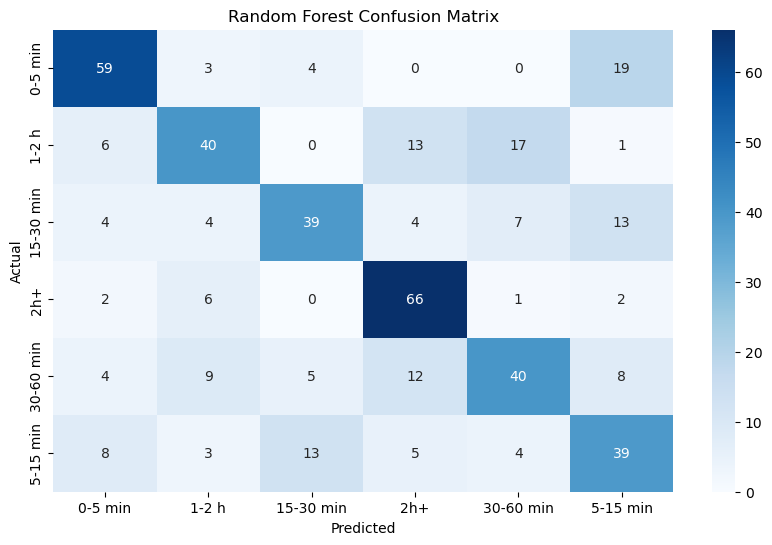

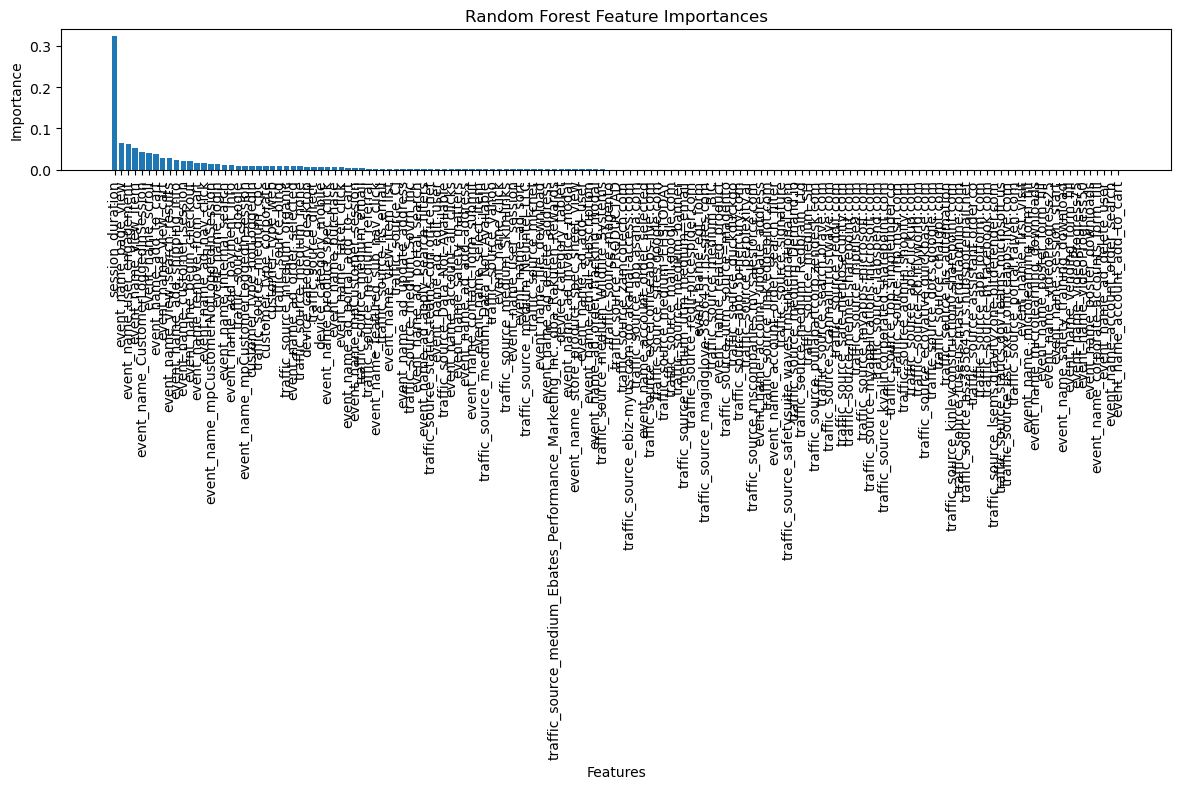

In [56]:
# random forest with hypertuning
rf = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_
print("Best parameters for Random Forest:", grid_search_rf.best_params_)
print("Best cross-validation score for Random Forest:", grid_search_rf.best_score_)

# save the best random forest model
joblib.dump(best_rf, 'best_random_forest_model.pkl')
# load the best random forest model
best_rf = joblib.load('best_random_forest_model.pkl')

# evaluate the random forest model on the test set
y_pred_rf = best_rf.predict(X_test)
print("Random Forest Test accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# visualize the confusion matrix for random forest
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_pred_rf), yticklabels=np.unique(y_pred_rf))
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# feature importance for random forest
feature_importances_rf = best_rf.feature_importances_
indices_rf = np.argsort(feature_importances_rf)[::-1]
plt.figure(figsize=(12, 8))
plt.title("Random Forest Feature Importances")
plt.bar(range(X.shape[1]), feature_importances_rf[indices_rf], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices_rf], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# save feature importance to csv for random forest
feature_importance_rf_df = pd.DataFrame({
    'feature': X.columns[indices_rf],
    'importance': feature_importances_rf[indices_rf]
})
feature_importance_rf_df.to_csv('rf_feature_importances.csv', index=False)

MLP Test accuracy: 0.15434782608695652
              precision    recall  f1-score   support

     0-5 min       0.00      0.00      0.00        85
       1-2 h       0.00      0.00      0.00        77
   15-30 min       0.15      1.00      0.27        71
         2h+       0.00      0.00      0.00        77
   30-60 min       0.00      0.00      0.00        78
    5-15 min       0.00      0.00      0.00        72

    accuracy                           0.15       460
   macro avg       0.03      0.17      0.04       460
weighted avg       0.02      0.15      0.04       460



c:\Users\laptop\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\laptop\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\laptop\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


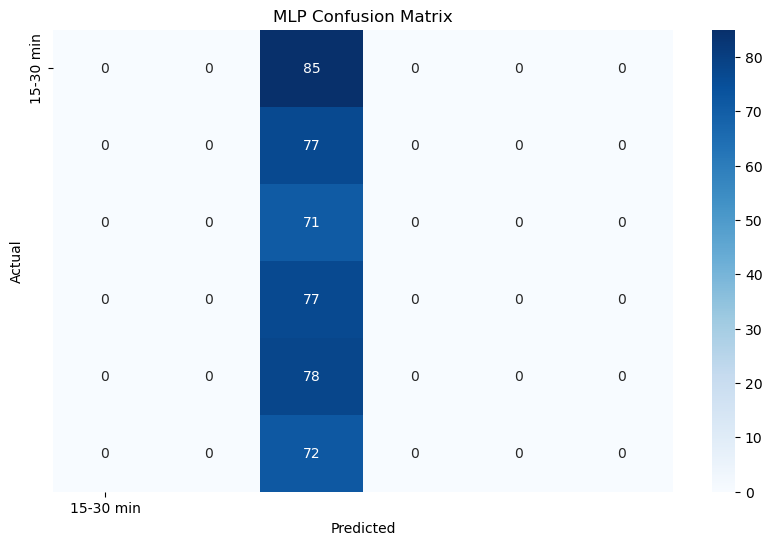

In [60]:
# train MLP Classifier
mlp = MLPClassifier(random_state=42, max_iter=500, 
                    hidden_layer_sizes=(100, 50), activation='logistic', solver='adam',
                    learning_rate_init=0.001, early_stopping=False,
                    batch_size='auto', alpha=1e-07, tol=0.0001)
mlp.fit(X_train, y_train)


# save the best MLP model
joblib.dump(mlp, 'best_mlp_model.pkl')
# load the best MLP model
mlp = joblib.load('best_mlp_model.pkl')

# evaluate the MLP model on the test set
y_pred_mlp = mlp.predict(X_test)
print("MLP Test accuracy:", accuracy_score(y_test, y_pred_mlp))
print(classification_report(y_test, y_pred_mlp))

# visualize the confusion matrix for MLP
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_mlp), annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_pred_mlp), yticklabels=np.unique(y_pred_mlp))
plt.title("MLP Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Session duration is playing the most significant role, if we drop this feature...

Best parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best cross-validation score: 0.2992240255893851
Test accuracy: 0.28695652173913044
              precision    recall  f1-score   support

     0-5 min       0.47      0.59      0.52        85
       1-2 h       0.30      0.31      0.31        77
   15-30 min       0.20      0.41      0.27        71
         2h+       0.53      0.10      0.17        77
   30-60 min       0.25      0.04      0.07        78
    5-15 min       0.17      0.25      0.20        72

    accuracy                           0.29       460
   macro avg       0.32      0.28      0.26       460
weighted avg       0.33      0.29      0.26       460



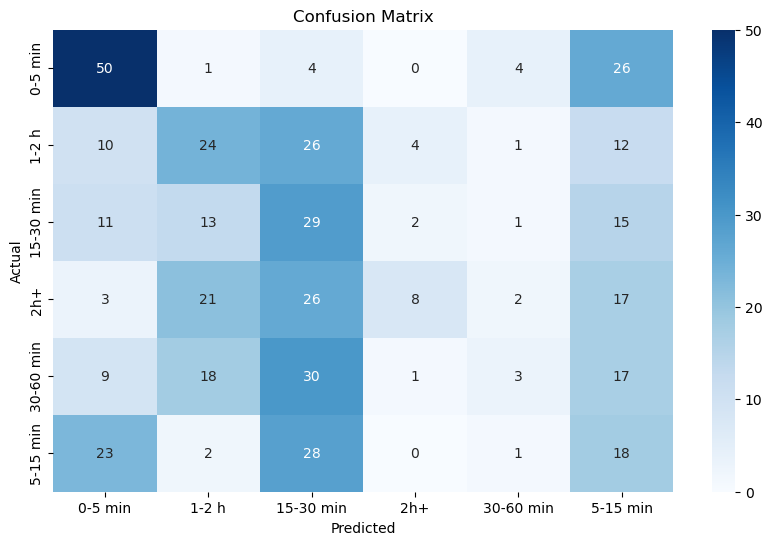

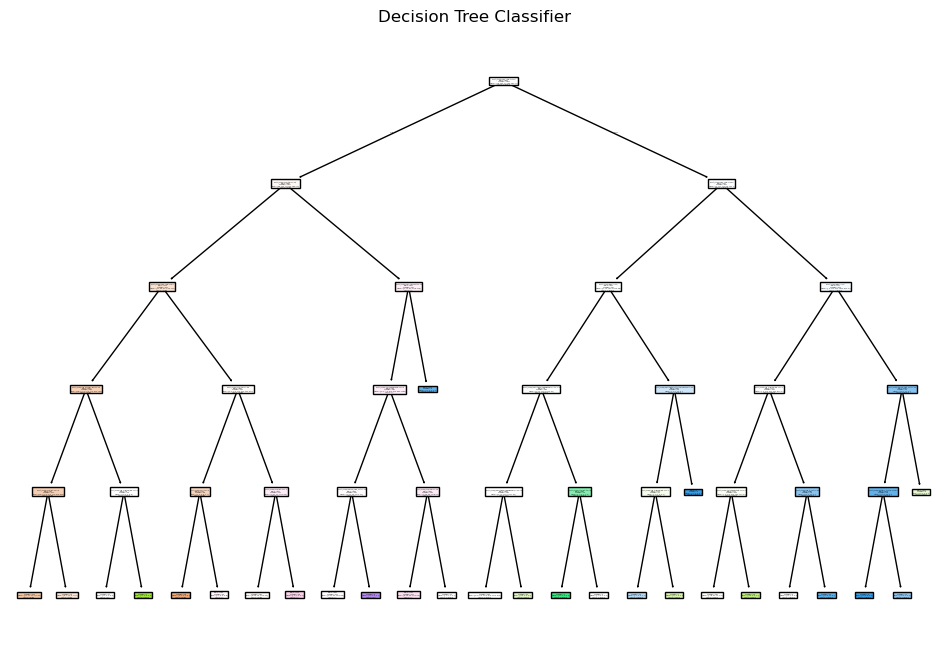

<Figure size 640x480 with 0 Axes>

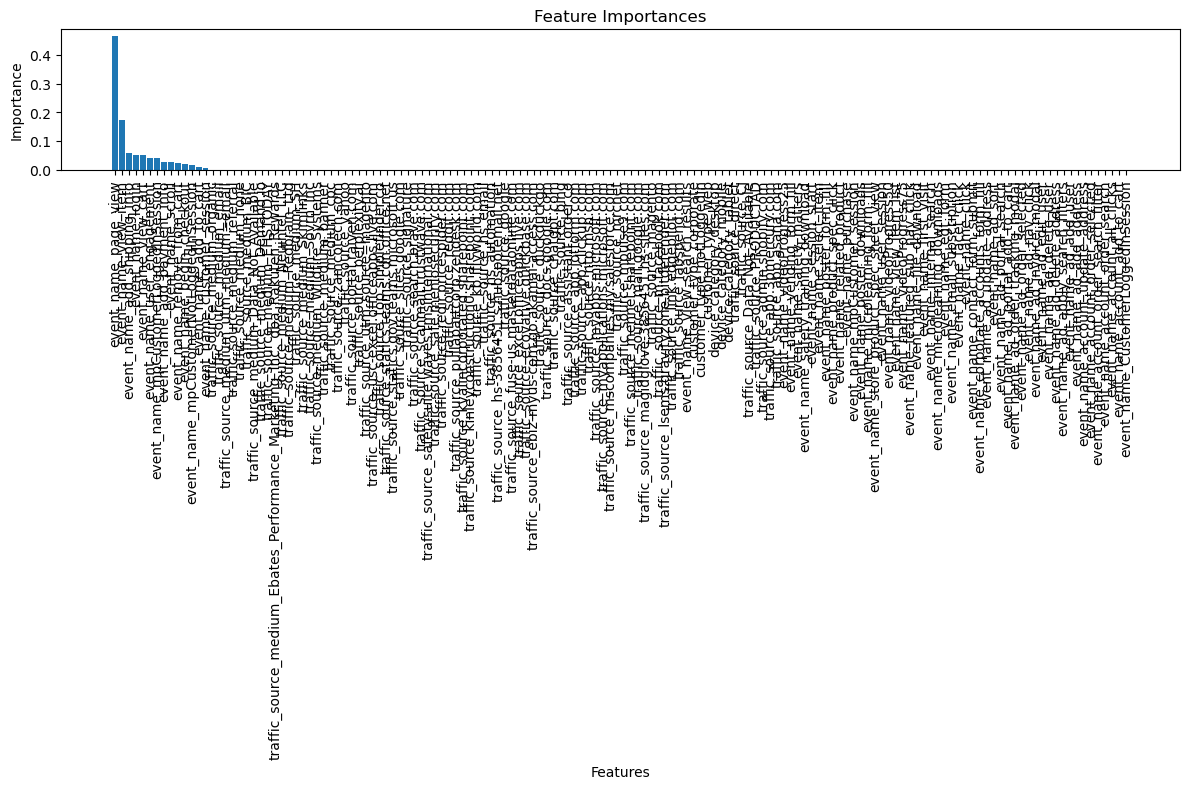

In [ ]:
y = final_input_2['time_to_conversion']
X = final_input_2.drop(columns=['user_pseudo_id', 'session_id', 'time_to_conversion', 'session_duration'])

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train a decision tree classifier with hypertuning
dt = DecisionTreeClassifier(random_state=42)
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_dt = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# save the best model
joblib.dump(best_dt, 'best_decision_tree_model_without_session_duration.pkl')

# load the best model
best_dt = joblib.load('best_decision_tree_model_without_session_duration.pkl')

# evaluate the model on the test set
y_pred = best_dt.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# visualize the confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_pred), yticklabels=np.unique(y_pred))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# visualize the decision tree
plt.figure(figsize=(12, 8))
plot_tree(best_dt, filled=True, feature_names=X.columns, class_names=y.cat.categories)
plt.title("Decision Tree Classifier")
plt.show()

# save the decision tree plot
plt.savefig('decision_tree_classifier_without_session_duration.png', bbox_inches='tight')

# feature importance
feature_importances = best_dt.feature_importances_
indices = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), feature_importances[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# save feature importance to csv
feature_importance_df = pd.DataFrame({
    'feature': X.columns[indices],
    'importance': feature_importances[indices]
})
feature_importance_df.to_csv('dt_feature_importances_without_session_duration.csv', index=False)
